# Well Multiphase Production Performance Prediction Using Deep Learning 

## Libraries Loading 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense, LSTM, CuDNNLSTM, Dropout, Activation,GRU
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

path = 'plot_DL/F-1/'

Using TensorFlow backend.


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


##  Data loading and preparation

In [3]:
data =pd.read_excel('data/data_well_f1-select.xlsx', sheet_name= 'Sheet1')

In [4]:
data.head()

,DATEPRD,NPD_WELL_BORE_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,OIL_RATE,GAS_RATE,WAT_RATE,WAT_CUT,TIME
0,2014-04-11,15/9-F-1 C,0.0,310.37614,96.87589,277.27826,1.215987,33.09788,10.47992,33.07195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2014-04-12,15/9-F-1 C,0.0,303.50078,96.92339,281.44744,3.087015,22.05334,8.70429,22.05334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2014-04-13,15/9-F-1 C,0.0,303.53481,96.95885,276.03200,1.962365,27.50281,9.42315,16.16326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2014-04-14,15/9-F-1 C,0.0,303.78228,96.96873,282.78676,0.000000,20.99552,8.13137,20.73712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,2014-04-15,15/9-F-1 C,0.0,303.85821,97.02136,289.94067,31.141856,13.91754,8.49833,12.18153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


* We remove DATEPRD and NPD_WELL_BORE_NAME variables
* We remove also BORE_OIL_VOL, BORE_GAS_VOL, BORE_WAT_VOL since they are used to compute the target variables

In [5]:
Data = data.drop(['ON_STREAM_HRS','DATEPRD', 'NPD_WELL_BORE_NAME','BORE_OIL_VOL','BORE_GAS_VOL','BORE_WAT_VOL', 'WAT_CUT'], axis = 'columns', inplace = False)

### Features selection

The correlation describes the strength of the linear association between two variables. It summarizes the strength and direction of the linear (straight-line) association between two quantitative variables. 

#### Target variables associations: 
    Based on the correlation matrix: 
    - we can notice that 'GAS_RATE' and 'OIL_RATE' variabales are highly correlated; their correlation estimated by 0.97. 
    - 'WAT_RATE' is slightly negatively correlated with the GAS and OIL rates variables.  

,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,OIL_RATE,GAS_RATE,WAT_RATE,TIME
AVG_DOWNHOLE_PRESSURE,1.000000,-0.794853,0.470906,-0.674969,0.354863,-0.674607,0.565699,-0.605992,-0.617525,-0.314425,0.315973
AVG_DOWNHOLE_TEMPERATURE,-0.794853,1.000000,-0.231616,0.928418,-0.433278,0.934716,-0.633928,0.729855,0.746578,0.652619,-0.250031
AVG_DP_TUBING,0.470906,-0.231616,1.000000,-0.122192,-0.657662,-0.131176,-0.430201,-0.358506,-0.353567,0.174861,0.198842
AVG_CHOKE_SIZE_P,-0.674969,0.928418,-0.122192,1.000000,-0.446873,0.953654,-0.629991,0.729156,0.746178,0.727516,-0.231626
AVG_WHP_P,0.354863,-0.433278,-0.657662,-0.446873,1.000000,-0.437042,0.938978,-0.137532,-0.152613,-0.453806,0.059087
AVG_WHT_P,-0.674607,0.934716,-0.131176,0.953654,-0.437042,1.000000,-0.615115,0.707220,0.723711,0.780176,-0.148774
DP_CHOKE_SIZE,0.565699,-0.633928,-0.430201,-0.629991,0.938978,-0.615115,1.000000,-0.307196,-0.324091,-0.546362,0.123214
OIL_RATE,-0.605992,0.729855,-0.358506,0.729156,-0.137532,0.707220,-0.307196,1.000000,0.995817,0.269347,-0.511913
GAS_RATE,-0.617525,0.746578,-0.353567,0.746178,-0.152613,0.723711,-0.324091,0.995817,1.000000,0.290214,-0.503404
WAT_RATE,-0.314425,0.652619,0.174861,0.727516,-0.453806,0.780176,-0.546362,0.269347,0.290214,1.000000,0.293786


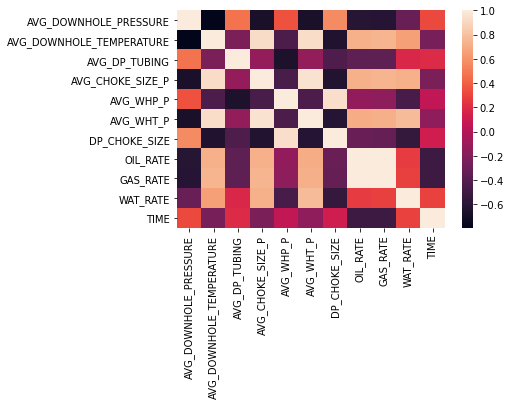

In [6]:
corr = Data.corr()
#corr_data = pd.DataFrame(corr)
sns.heatmap(corr)
corr

* We can see the linear relationship between the OIL and GAS rates using the scatter plot. 

Text(0, 0.5, 'Gas rate')

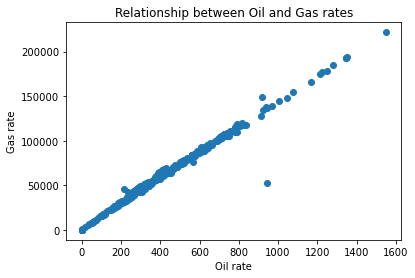

In [7]:
plt.scatter(Data['OIL_RATE'], Data['GAS_RATE'])
plt.title('Relationship between Oil and Gas rates')
plt.xlabel('Oil rate')
plt.ylabel('Gas rate')

* They even share the same distribution, normal distribution with some outliers in the same levels. 
We can conclude that the prediction of one variable implies the other.

<AxesSubplot:>

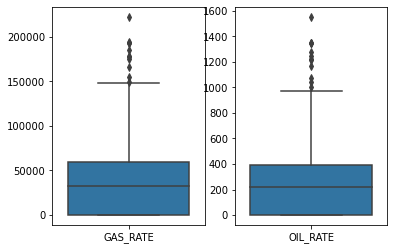

In [8]:
plt.subplot(1, 2, 1)
sns.boxplot( data=Data, order= ['GAS_RATE'])

plt.subplot(1, 2, 2)
sns.boxplot( data=Data, order= ['OIL_RATE'])

#### Predictors relationship with the target variables: 

* In order to avoid multicollinearity, we compare the correlation between features and remove one of two features that have a correlation higher than 0.9


In [9]:
datafeatures = Data.drop(['OIL_RATE', 'GAS_RATE', 'WAT_RATE', 'TIME'], axis = 'columns', inplace = False)
corr = datafeatures.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
print(columns)
selected_columns = datafeatures.columns[columns]
newdata = datafeatures[selected_columns]
newdata['Time'] = Data['TIME']
newdata['OIL_RATE'] = Data['OIL_RATE'] 
newdata['GAS_RATE'] = Data['GAS_RATE'] 
newdata['WAT_RATE'] = Data['WAT_RATE']


[ True  True  True False  True False False]


C:\Users\fabia\anaconda3\envs\dlearn\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\fabia\anaconda3\envs\dlearn\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [10]:
newdata.shape

(741, 8)

In [11]:
newdata.columns

Index(['AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING',
       'AVG_WHP_P', 'Time', 'OIL_RATE', 'GAS_RATE', 'WAT_RATE'],
      dtype='object')

### Data Structure: 
* We prepare the data so it can be fed into the neural network models. We'll check first the dimension of the features and targets data. 

In [12]:
newdata.head()
newdata = newdata.dropna()
newdata.shape

(741, 8)

In [13]:
# Non Array
Features = newdata.iloc[:,:-3]
print('the features data X is of dimension', Features.shape)
Targets = newdata.iloc[:,-3:]
print('the targets data Y is of dimension', Targets.shape)

the features data X is of dimension (741, 5)
the targets data Y is of dimension (741, 3)


In [14]:
# Array
features = newdata.iloc[:,:-3].values
print('the features data X is of dimension', features.shape)
targets = newdata.iloc[:,-3:].values
print('the targets data Y is of dimension', targets.shape)

the features data X is of dimension (741, 5)
the targets data Y is of dimension (741, 3)


In [15]:
newdata.iloc[:,:-4]

,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_WHP_P
0,310.37614,96.87589,277.27826,33.09788
1,303.50078,96.92339,281.44744,22.05334
2,303.53481,96.95885,276.03200,27.50281
3,303.78228,96.96873,282.78676,20.99552
4,303.85821,97.02136,289.94067,13.91754
...,...,...,...,...
736,266.14787,101.17000,257.47316,8.67471
737,270.26849,101.19807,263.77035,6.49814
738,276.86895,101.23102,263.15498,13.71397
739,282.10538,101.17754,273.52959,8.57579



A good rule of thumb is that normalized data lead to better performance in Neural Networks. In this project, use MinMaxScaler from sklearn. We apply MinMaxScaler on the data so the high values would not take more attention than the others.



It is important to ensure that the scale of the output variable is in the range 0-1 to match the scale of the activation function (tanh) on the output layer of LSTM/GRU. Also, input variables are better to be small values, probably in the range of 0-1.

What are the steps?

- Fit the scaler using available training data (It means that the minimum and maximum observable values are estimated using training data.)

- Apply the scaler to training data

- Apply the scaler to test data

It is important to note that we should scale the unseen data with the scaler fitted on the training data.

In [16]:
scaler_x = MinMaxScaler()
scaler_y= MinMaxScaler()


x = scaler_x.fit_transform(features)
Y = scaler_y.fit_transform(targets)

* The LSTM model input dimension requires the third dimension that will be the number of the single input row. We'll reshape the X data 

In [17]:
X = x.reshape(x.shape[0], x.shape[1], 1)

* We can split the data into the train, test and validation parts; 70% of the data for training set and the remaining 30% for the testing and validation sets.

**Method 1**

In [18]:
# Method 1
Xtrv, Xtest, Ytrv, Ytest = train_test_split(X,Y,test_size=0.15,train_size=0.85)
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrv,Ytrv,test_size = 0.15,train_size =0.7)
print('Dimension of data: ',X.shape)
print('Dimension of train data: ',Xtrain.shape)
print('Dimension of test data: ', Xval.shape)
print('Dimension of test data: ', Xtest.shape)
print('Dimension of data (calculated)', Xtrain.shape[0]+ Xval.shape[0]+ Xtest.shape[0])

Dimension of data:  (741, 5, 1)
Dimension of train data:  (440, 5, 1)
Dimension of test data:  (95, 5, 1)
Dimension of test data:  (112, 5, 1)
Dimension of data (calculated) 647


=========================================================================================================================

**Method 2**

In [19]:
# Method 2
#trv_size = int(len(scaled_data)*0.85)
#train_size = int(len(scaled_data)*0.7)
#val_size = int(len(scaled_data)*0.15)
#train_dataset, val_dataset, test_dataset = scaled_data.iloc[:train_size], scaled_data.iloc[train_size: train_size+val_size], newdata.iloc[train_size+val_size:]
#trv_size =  newdata.iloc[:trv_size]

#print('Dimension of data: ',newdata.shape)
#print('Dimension of train data: ',train_dataset.shape)
#print('Dimension of test data: ', val_dataset.shape)
#print('Dimension of test data: ', test_dataset.shape)
#print('Dimension of data (calculated)', train_dataset.shape[0]+val_dataset.shape[0]+test_dataset.shape[0])

In [20]:
#xtrain, xval, xtest = Features.iloc[:train_size], Features.iloc[train_size: train_size+val_size], Features.iloc[train_size+val_size:]
#ytrain, yval, ytest = Targets.iloc[:train_size], Targets.iloc[train_size: train_size+val_size], Targets.iloc[train_size+val_size:]


#print('Dimension of train data: ',xtrain.shape)
#print('Dimension of test data: ', xval.shape)
#print('Dimension of test data: ', xtest.shape)
#print('Dimension of data (calculated)', xtrain.shape[0]+ xval.shape[0]+ xtest.shape[0])

In [21]:
#train_x_norm, val_x_norm, test_x_norm = scaler_x.fit_transform(xtrain), scaler_x.fit_transform(xval), scaler_x.fit_transform(xtest)
#train_y_norm, val_y_norm, test_y_norm = scaler_y.fit_transform(ytrain), scaler_y.fit_transform(yval), scaler_x.fit_transform(ytest)
#print('Dimension of train data: ',train_x_norm.shape)
#print('Dimension of test data: ', val_x_norm.shape)
#print('Dimension of test data: ', test_x_norm.shape)

In [22]:
#def create_dataset (X, y, time_steps = 1):
#    Xs, ys = [], []
#    
#    for i in range(len(X)-time_steps):
#        v = X[i:i+time_steps, :]
#        Xs.append(v)
#        ys.append(y[i+time_steps])
#        
#    return np.array(Xs), np.array(ys)

In [23]:
#TIME_STEPS = 10
#
#Xtrain, Ytrain = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
#Xval, Yval = create_dataset(val_x_norm, val_y_norm, TIME_STEPS)
#Xtest, Ytest = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
#
#print('X_train.shape: ', Xtrain.shape)
#print('y_train.shape: ', Ytrain.shape)
#print('X_val.shape: ', Xval.shape) 
#print('y_val.shape: ', Yval.shape)
#print('X_test.shape: ', Xtest.shape) 
#print('y_test.shape: ', Ytest.shape)

In [24]:
#Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], 1)
#Xval = Xval.reshape(Xval.shape[0], Xval.shape[1], 1)
#Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], 1)
#print('Dimension of train data: ',Xtrain.shape)
#print('Dimension of test data: ', Xval.shape)
#print('Dimension of test data: ', Xtest.shape)

=========================================================================================================================

* Then we will define the input and output data dimensions from X and Y data. Define different scalers for input and output as they have different shapes. This is especially important for using inverse transform function.

In [25]:
input_dimension  = Xtrain.shape[1:]
output_dimension = Ytrain.shape[1]

## Evaluation Metrics

In [26]:
def rae(actual: np.ndarray, predicted: np.ndarray):
    """ Relative Absolute Error """
    return np.sum(np.abs(actual - predicted)) / np.sum(np.abs(actual - np.mean(actual)))

def rse(actual, predicted):
    """ Relative Squared Error """
    return np.sum((predicted - actual)**2) / np.sum((actual - np.mean(actual))**2)

## Modeling

* We will build two neural networks architectures to predict the triplet (OIL_RATE, GAS_RATE, WAT_RATE). 


#### 1. LSTM Model: 

* We will start by defining the sequential model. The sequential model contains LSTM layers with ReLU activations, Dense output layer,  and Adam optimizer with MSE loss function. We will set the input dimension in the first layer and output dimension in the last layer of the model.
* Then, we will fit the model with train data.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 66,947
Trainable params: 66,947
Non-trainable params: 0
_________________________________________________________________
Train on 440 samples, validate on 95 samples
Epoch 1/100
440/440 [==============================] - 1s 2ms/step - loss: 0.0422 - val_loss: 0.0433
Epoch 2/100
440/440 [==============================] - 0s 835us/step - loss: 0.0362 - val_loss: 0.0390
Epoch 3/100
440/440 [==============================] - 0s 841us/step - loss: 0.0338 - val_loss: 0.0351
Epoch 4/100
440/440 [==============================] - 0s 861us/step - loss: 0.0297 - val_loss: 0.0320
Epoch 5/100
440/440 [==============================] - 0s

440/440 [==============================] - 0s 853us/step - loss: 0.0033 - val_loss: 0.0043
Epoch 74/100
440/440 [==============================] - 0s 861us/step - loss: 0.0036 - val_loss: 0.0057
Epoch 75/100
440/440 [==============================] - 0s 845us/step - loss: 0.0032 - val_loss: 0.0039
Epoch 76/100
440/440 [==============================] - 0s 850us/step - loss: 0.0033 - val_loss: 0.0031
Epoch 77/100
440/440 [==============================] - 0s 866us/step - loss: 0.0032 - val_loss: 0.0048
Epoch 78/100
440/440 [==============================] - 0s 845us/step - loss: 0.0035 - val_loss: 0.0037
Epoch 79/100
440/440 [==============================] - 0s 852us/step - loss: 0.0029 - val_loss: 0.0033
Epoch 80/100
440/440 [==============================] - 0s 850us/step - loss: 0.0031 - val_loss: 0.0034
Epoch 81/100
440/440 [==============================] - 0s 873us/step - loss: 0.0033 - val_loss: 0.0042
Epoch 82/100
440/440 [==============================] - 0s 889us/step - loss:

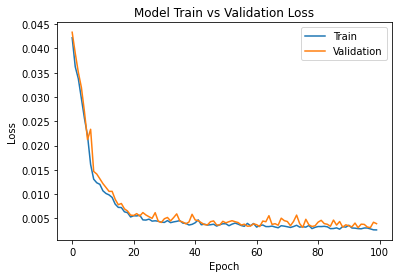

In [27]:
from keras import optimizers

#optimizer = optimizers.Adam(clipvalue=1.e-10)

model = Sequential()
model.add(LSTM(128, input_shape=input_dimension, activation="relu"))
model.add(Dense(output_dimension))
model.compile(loss="mse", optimizer="adam") 
model.summary()
history = model.fit(Xtrain, Ytrain, batch_size=5, validation_data=(Xval, Yval), epochs=100)
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Model Train vs Validation Loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Validation'], loc='upper right')
pyplot.show()

#### Testing Overfitting and Underfitting: 
* To test if our model overfitting or underfitted on the data sample, we use the traning and validation sets 
* Based on the loss function plot of  training and validation sets, we can notice that the loss decreases until the 60th epoch

* We train the model and then we test it on the testing data.

In [28]:
model = Sequential()
model.add(LSTM(128, input_shape=input_dimension, activation="relu"))
model.add(Dense(output_dimension))
model.compile(loss="mse", optimizer="adam") 
model.summary()
history = model.fit(Xtrain, Ytrain, batch_size=5, epochs=70, verbose = 0)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 66,947
Trainable params: 66,947
Non-trainable params: 0
_________________________________________________________________


#### Results prediction and visualization :

* We will predict test data and we check the mean squared error (MSE), the relative squared error (RSE) and the relative abolute error (RAE).

In [29]:
predictionsLSTM = model.predict(Xtest)

* We plot the result of predictions in the following graph by doing inversion first: 

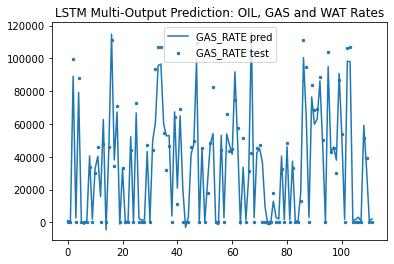

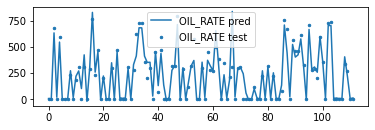

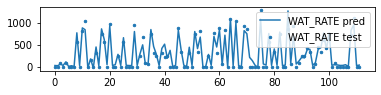

In [30]:
Predictionsinversed = scaler_y.inverse_transform(predictionsLSTM)
Ytestinversed = scaler_y.inverse_transform(Ytest)

axis = range(len(Xtest))
plt.subplot(1, 1, 1)
plt.title("LSTM Multi-Output Prediction: OIL, GAS and WAT Rates")
plt.scatter(axis, Ytestinversed[:,1],  s=6, label="GAS_RATE test")
plt.plot(axis, Predictionsinversed[:,1], label="GAS_RATE pred")

plt.legend()
plt.show()
plt.subplot(2, 1, 1)
plt.scatter(axis, Ytestinversed[:,0],  s=6, label="OIL_RATE test")
plt.plot(axis, Predictionsinversed[:,0], label="OIL_RATE pred")
plt.legend()
plt.show()
plt.subplot(3, 1, 1)
plt.scatter(axis, Ytestinversed[:,2],  s=6, label="WAT_RATE test")
plt.plot(axis, Predictionsinversed[:,2], label="WAT_RATE pred")

plt.legend()
plt.show()

##### RAE and RSE Test

In [31]:
print("Relative Absolute Error metric using LSTM model")

print("OIL_RATE RAE:%.4f" % rae(Ytestinversed[:,0], Predictionsinversed[:,0]))
print("GAS_RATE RAE:%.4f" % rae(Ytestinversed[:,1], Predictionsinversed[:,1])) 
print("WAT_RATE RAE:%.4f" % rae(Ytestinversed[:,2], Predictionsinversed[:,2]))

print('\n')
print("Relative Squared Error metric using LSTM model")

print("OIL_RATE RSE:%.4f" % rse(Ytestinversed[:,0], Predictionsinversed[:,0]))
print("GAS_RATE RSE:%.4f" % rse(Ytestinversed[:,1], Predictionsinversed[:,1])) 
print("WAT_RATE RSE:%.4f" % rse(Ytestinversed[:,2], Predictionsinversed[:,2]))

Relative Absolute Error metric using LSTM model
OIL_RATE RAE:0.2001
GAS_RATE RAE:0.2058
WAT_RATE RAE:0.2250


Relative Squared Error metric using LSTM model
OIL_RATE RSE:0.1034
GAS_RATE RSE:0.0992
WAT_RATE RSE:0.0764


#### Full Visualization: LSTM

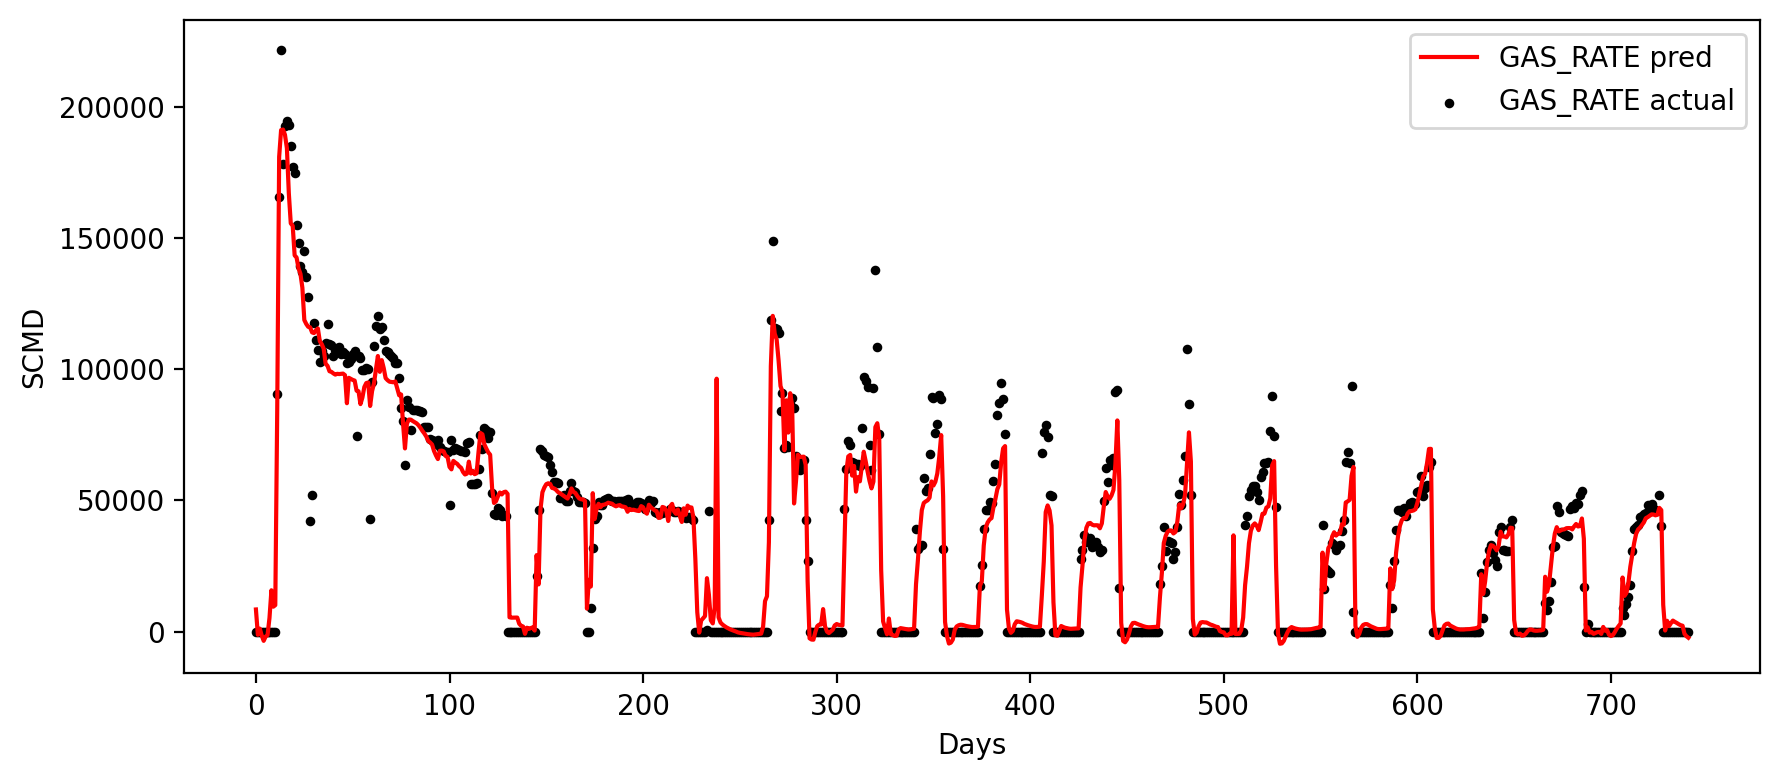

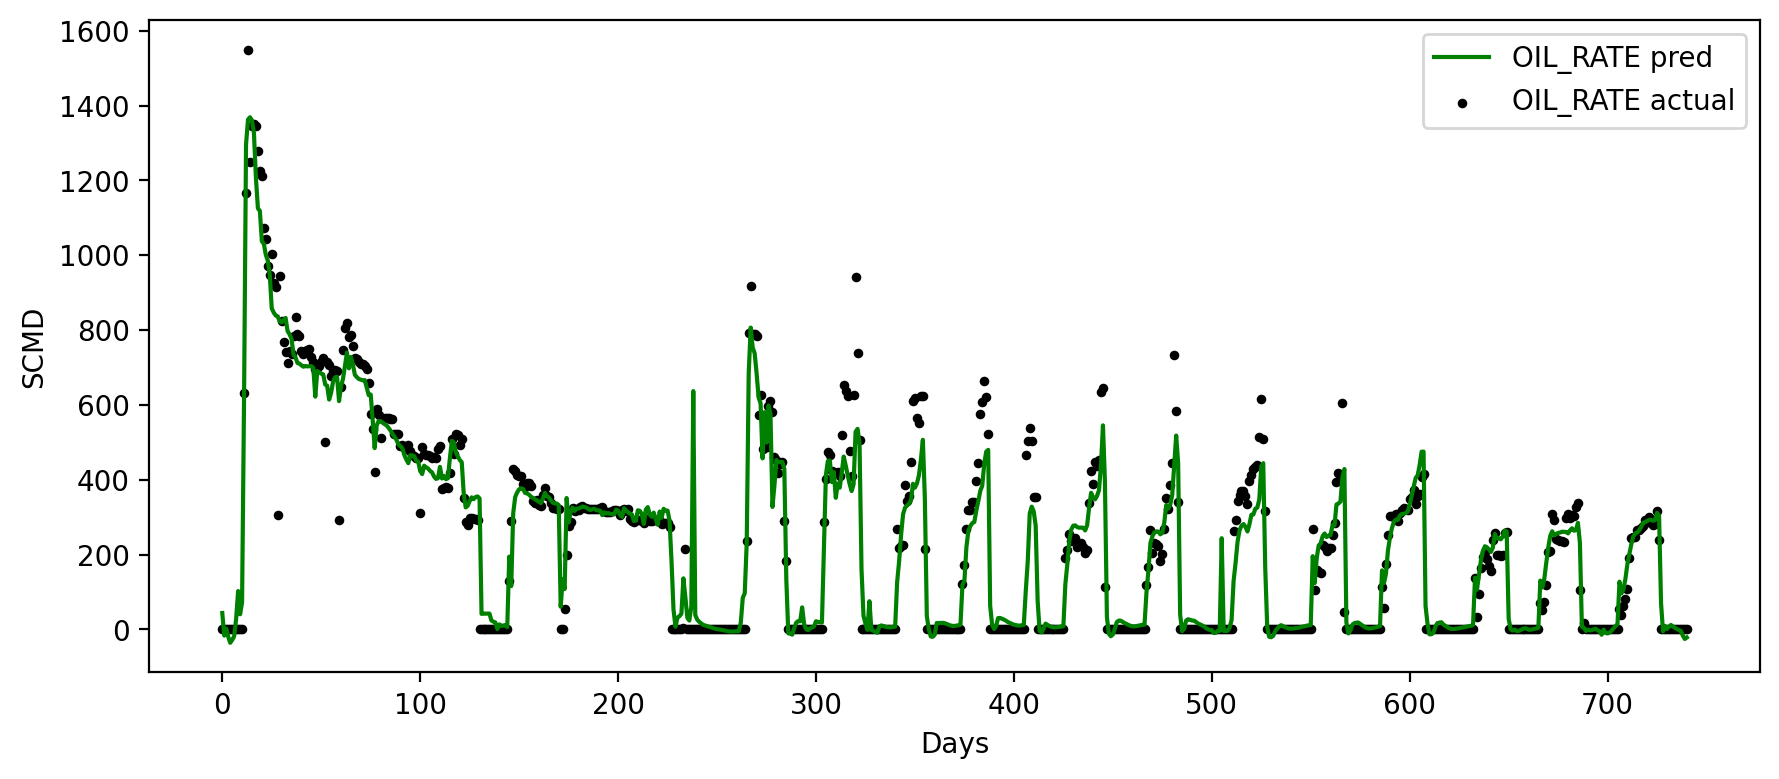

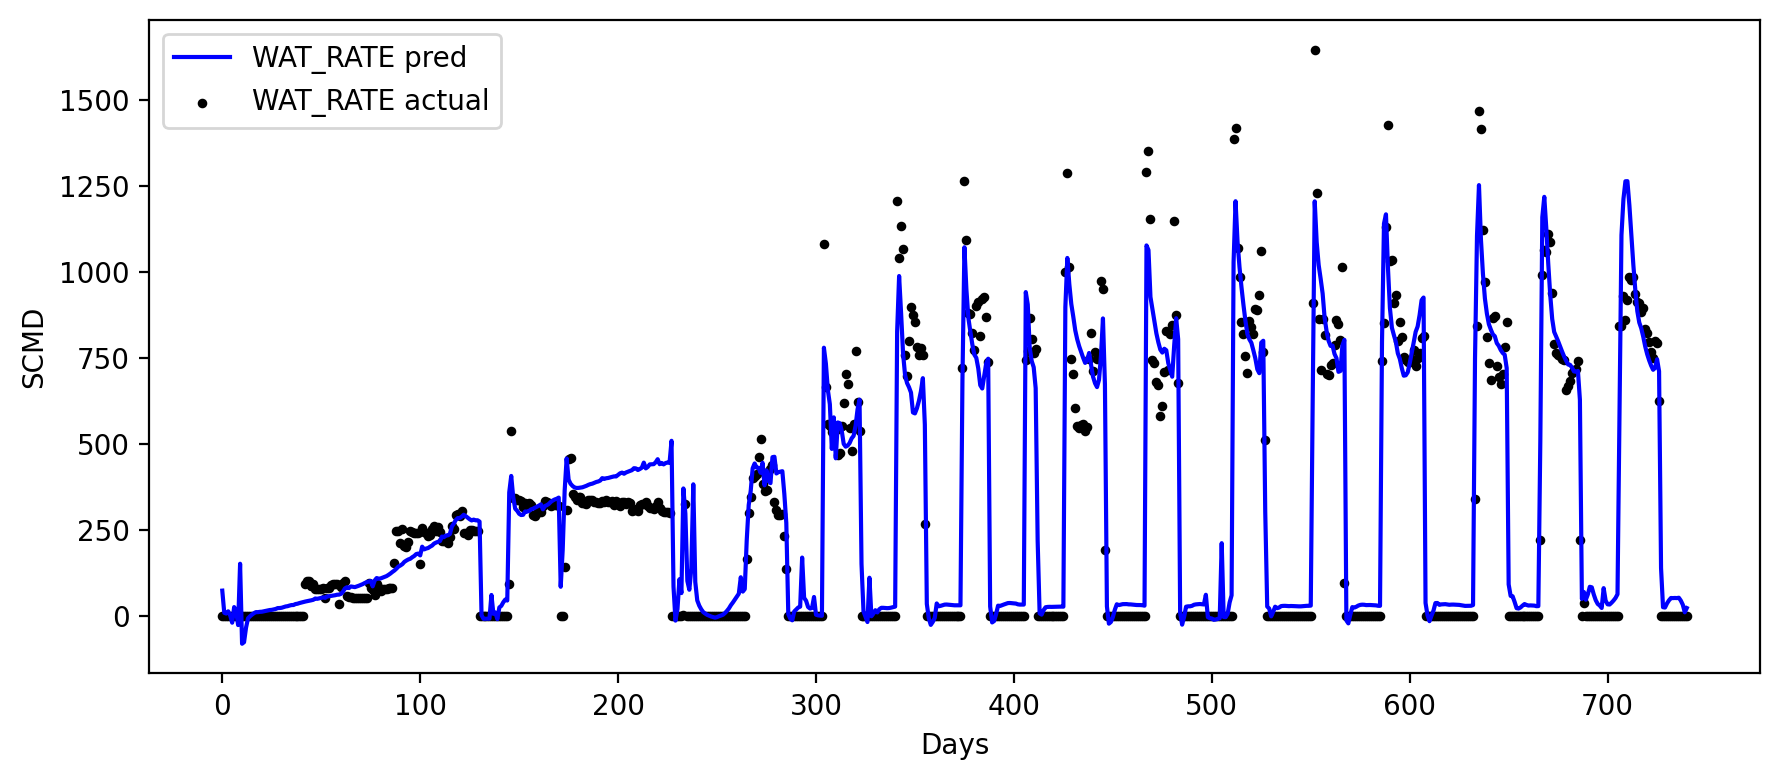

In [32]:
predictionsLSTM = model.predict(X)
Predictionsinversed = scaler_y.inverse_transform(predictionsLSTM)
Ytestinversed = scaler_y.inverse_transform(Y)

axis = newdata.iloc[:,-4].values
plt.figure(figsize=(9, 4), dpi=200)
# plt.scatter(axis, Ytestinversed[:,1],  s=6, c='r', label="GAS_RATE actual")
plt.scatter(axis, targets[:,1],  s=6, c='k', label="GAS_RATE actual")
plt.plot(axis, Predictionsinversed[:,1], 'r', label="GAS_RATE pred")
plt.legend()
plt.xlabel('Days')
plt.ylabel('SCMD')
plt.tight_layout()
exported = ('GAS RATE_LSTM' + '.png')
plt.savefig(path + exported)
plt.show()

#plt.subplot(2, 1, 1)
plt.figure(figsize=(9, 4), dpi=200)
# plt.scatter(axis, Ytestinversed[:,0],  s=6,c='r', label="OIL_RATE actual")
plt.scatter(axis, targets[:,0],  s=6, c='k', label="OIL_RATE actual")
plt.plot(axis, Predictionsinversed[:,0], 'g' , label="OIL_RATE pred")
plt.legend()
plt.xlabel('Days')
plt.ylabel('SCMD')
plt.tight_layout()
exported = ('OIL RATE_LSTM' + '.png')
plt.savefig(path + exported)
plt.show()

#plt.subplot(3, 1, 1)
plt.figure(figsize=(9, 4), dpi=200)
# plt.scatter(axis, Ytestinversed[:,2],  s=6, c='r', label="WAT_RATE actual")
plt.scatter(axis, targets[:,2],  s=6, c='k', label="WAT_RATE actual")
plt.plot(axis, Predictionsinversed[:,2], 'b',label="WAT_RATE pred")
plt.legend()
plt.xlabel('Days')
plt.ylabel('SCMD')
plt.tight_layout()
exported = ('WATER RATE_LSTM' + '.png')
plt.savefig(path + exported)
plt.show()

#### 2. GRU Model
* Based on the history plot, we set the epoch parameter to 65

Train on 440 samples, validate on 95 samples
Epoch 1/100
440/440 [==============================] - 1s 2ms/step - loss: 0.0409 - val_loss: 0.0402
Epoch 2/100
440/440 [==============================] - 0s 1ms/step - loss: 0.0352 - val_loss: 0.0356
Epoch 3/100
440/440 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.0223
Epoch 4/100
440/440 [==============================] - 0s 1ms/step - loss: 0.0191 - val_loss: 0.0178
Epoch 5/100
440/440 [==============================] - 0s 1ms/step - loss: 0.0138 - val_loss: 0.0118
Epoch 6/100
440/440 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0123
Epoch 7/100
440/440 [==============================] - 0s 1ms/step - loss: 0.0114 - val_loss: 0.0104
Epoch 8/100
440/440 [==============================] - 0s 1ms/step - loss: 0.0080 - val_loss: 0.0085
Epoch 9/100
440/440 [==============================] - 0s 1ms/step - loss: 0.0090 - val_loss: 0.0072
Epoch 10/100
440/440 [========================

Epoch 81/100
440/440 [==============================] - 1s 1ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 82/100
440/440 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 83/100
440/440 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 84/100
440/440 [==============================] - 1s 1ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 85/100
440/440 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 86/100
440/440 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 87/100
440/440 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 88/100
440/440 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0038
Epoch 89/100
440/440 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 90/100
440/440 [==============================] - 0s 1ms/step - loss: 0.0035

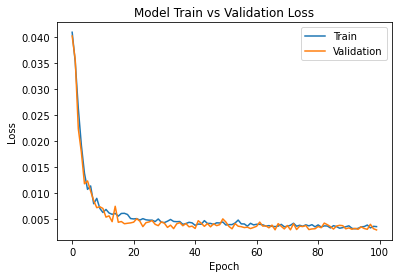

In [33]:
# scaler_x = MinMaxScaler()
# scaler_y= MinMaxScaler()

# x = scaler_x.fit_transform(features)
# Y = scaler_y.fit_transform(targets)
# X = x.reshape(x.shape[0], x.shape[1], 1)

# Xtrv, Xtest, Ytrv, Ytest = train_test_split(X,Y,test_size=0.15,train_size=0.85)
# Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrv,Ytrv,test_size = 0.15,train_size =0.7)

# input_dimension  = Xtrv.shape[1:]
# output_dimension = Ytrv.shape[1]

modelGRU = Sequential()
modelGRU.add(GRU(units=128, input_shape=input_dimension, return_sequences=False))
modelGRU.add(Activation('relu'))
modelGRU.add(Dropout(0.2))
modelGRU.add(Dense(output_dimension))
modelGRU.add(Activation('linear'))
modelGRU.compile(loss='mse', optimizer='adam')
history = modelGRU.fit(Xtrain, Ytrain, batch_size=5, validation_data=(Xval, Yval), epochs=100)
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Model Train vs Validation Loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Validation'], loc='upper right')
pyplot.show()

In [34]:
modelGRU = Sequential()
modelGRU.add(GRU(units=128, input_shape=input_dimension, return_sequences=False))
modelGRU.add(Activation('relu'))
modelGRU.add(Dropout(0.2))
modelGRU.add(Dense(output_dimension))
modelGRU.add(Activation('linear'))
modelGRU.compile(loss='mse', optimizer='adam')
modelGRU.fit(Xtrain, Ytrain, batch_size=5, validation_data=(Xval, Yval),epochs=65, verbose=0)

predictions = modelGRU.predict(Xtest)

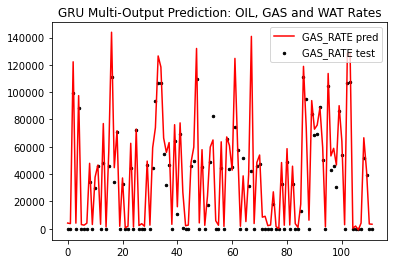

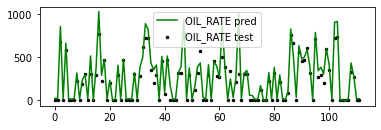

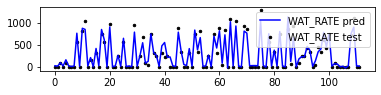

In [35]:
Predictionsinversed = scaler_y.inverse_transform(predictions)
Ytestinversed = scaler_y.inverse_transform(Ytest)

axis = range(len(Xtest))
plt.subplot(1, 1, 1)
plt.title("GRU Multi-Output Prediction: OIL, GAS and WAT Rates")
plt.scatter(axis, Ytestinversed[:,1],  s=6, c='k', label="GAS_RATE test")
plt.plot(axis, Predictionsinversed[:,1], 'r', label="GAS_RATE pred")


plt.legend()
plt.show()
plt.subplot(2, 1, 1)
plt.scatter(axis, Ytestinversed[:,0],  s=6, c='k', label="OIL_RATE test")
plt.plot(axis, Predictionsinversed[:,0], 'g', label="OIL_RATE pred")
plt.legend()
plt.show()

plt.subplot(3, 1, 1)
plt.scatter(axis, Ytestinversed[:,2],  s=6, c='k', label="WAT_RATE test")
plt.plot(axis, Predictionsinversed[:,2], 'b', label="WAT_RATE pred")
plt.legend()
plt.show()

In [36]:
print("Relative Absolute Error metric using GRU model")

print("OIL_RATE RAE:%.4f" % rae(Ytestinversed[:,0], Predictionsinversed[:,0]))
print("GAS_RATE RAE:%.4f" % rae(Ytestinversed[:,1], Predictionsinversed[:,1])) 
print("WAT_RATE RAE:%.4f" % rae(Ytestinversed[:,2], Predictionsinversed[:,2]))

print('\n')
print("Relative Squared Error metric using GRU model")

print("OIL_RATE RSE:%.4f" % rse(Ytestinversed[:,0], Predictionsinversed[:,0]))
print("GAS_RATE RSE:%.4f" % rse(Ytestinversed[:,1], Predictionsinversed[:,1])) 
print("WAT_RATE RSE:%.4f" % rse(Ytestinversed[:,2], Predictionsinversed[:,2]))

Relative Absolute Error metric using GRU model
OIL_RATE RAE:0.3000
GAS_RATE RAE:0.2984
WAT_RATE RAE:0.1878


Relative Squared Error metric using GRU model
OIL_RATE RSE:0.1961
GAS_RATE RSE:0.1752
WAT_RATE RSE:0.0613


#### Full Visualization: GRU

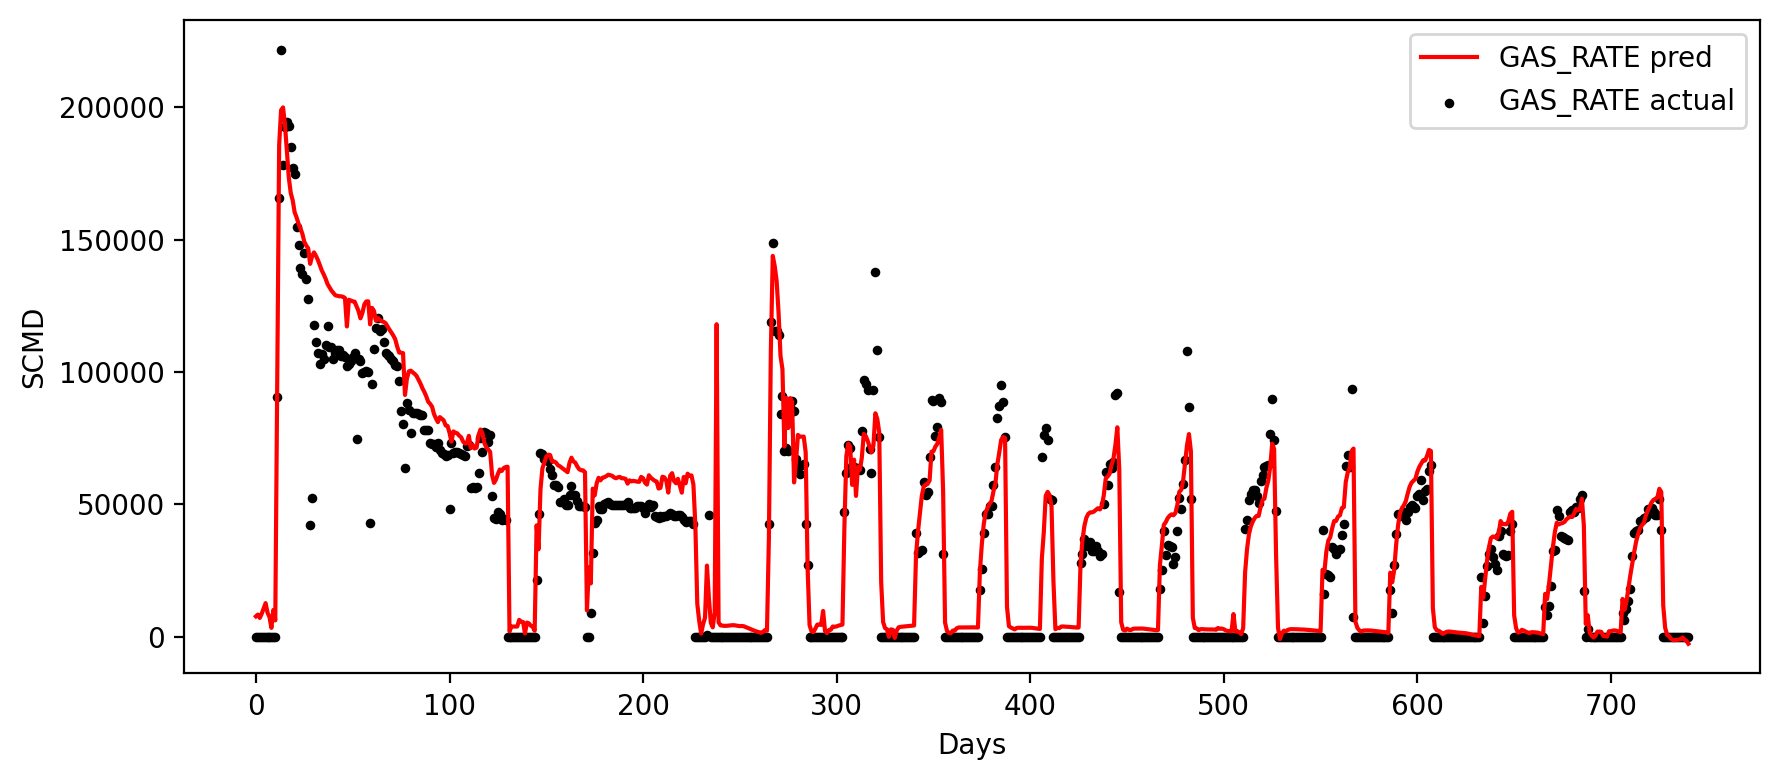

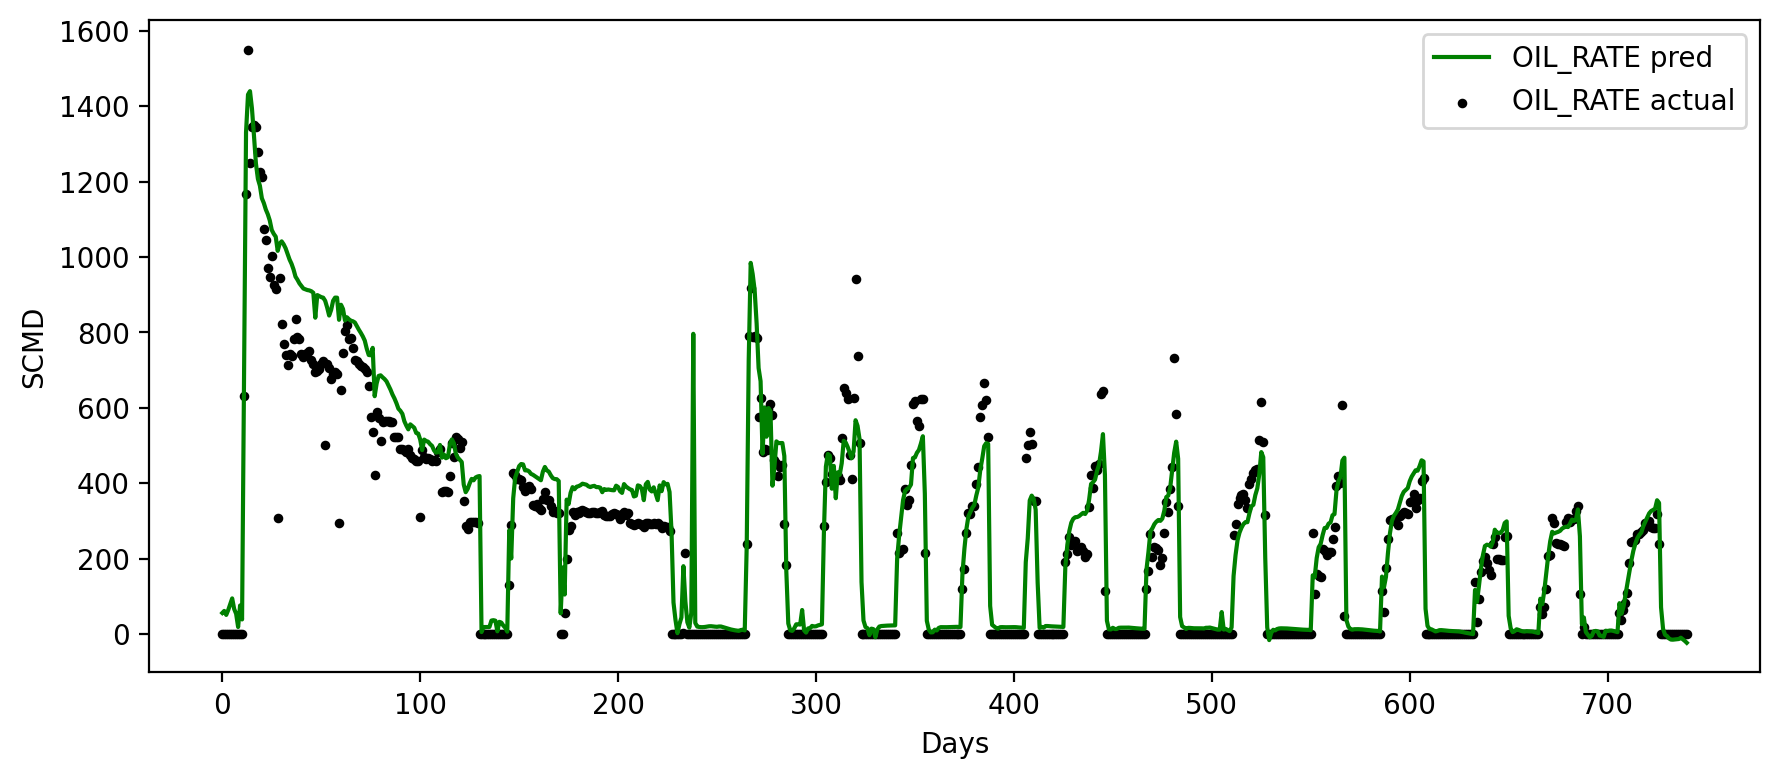

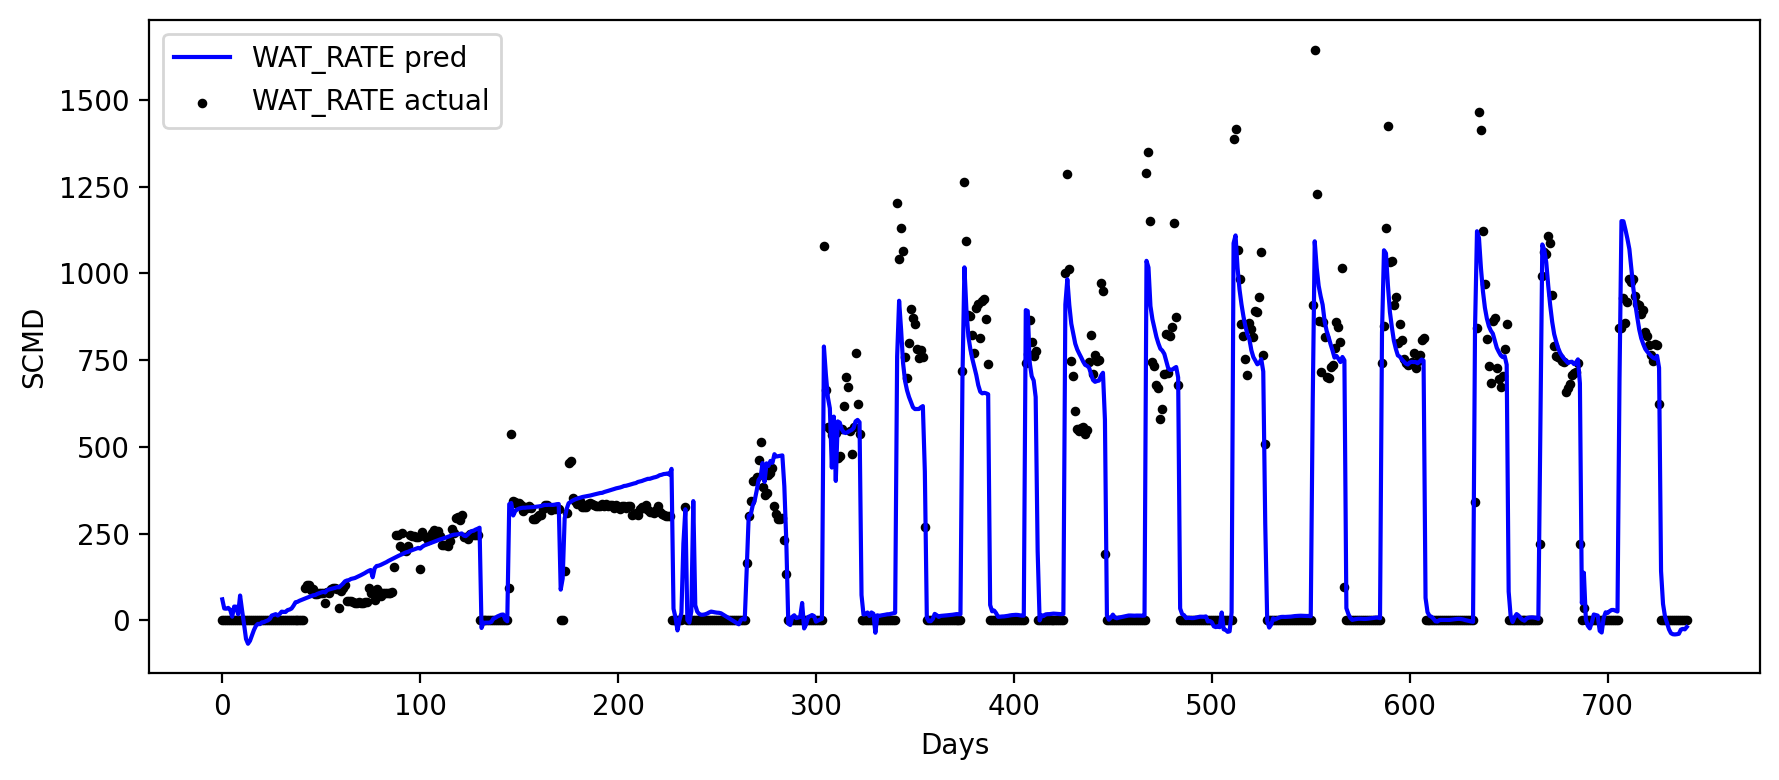

In [37]:
predictions = modelGRU.predict(X)

Predictionsinversed = scaler_y.inverse_transform(predictions)
#Ytestinversed = scaler_y.inverse_transform(Y)


axis = newdata.iloc[:,-4].values
#plt.subplot(1, 1, 1)
# plt.title("GRU Multi-Output Prediction: OIL, GAS and WAT Rates")
plt.figure(figsize=(9,4), dpi=200)
# plt.scatter(axis, Ytestinversed[:,1],  s=6, c='r', label="GAS_RATE actual")
plt.scatter(axis, targets[:,1],  s=6, c='k', label="GAS_RATE actual")
plt.plot(axis, Predictionsinversed[:,1], 'r', label="GAS_RATE pred")
plt.legend()
plt.xlabel('Days')
plt.ylabel('SCMD')
plt.tight_layout()
exported = ('GAS RATE_GRU' + '.png')
plt.savefig(path + exported)
plt.show()

#plt.subplot(2, 1, 1)
plt.figure(figsize=(9,4), dpi=200)
# plt.scatter(axis, Ytestinversed[:,0],  s=6,c='r', label="OIL_RATE actual")
plt.scatter(axis, targets[:,0],  s=6, c='k', label="OIL_RATE actual")
plt.plot(axis, Predictionsinversed[:,0], 'g' , label="OIL_RATE pred")
plt.legend()
plt.xlabel('Days')
plt.ylabel('SCMD')
plt.tight_layout()
exported = ('OIL RATE_GRU' + '.png')
plt.savefig(path + exported)
plt.show()

#plt.subplot(3, 1, 1)
plt.figure(figsize=(9, 4), dpi=200)
# plt.scatter(axis, Ytestinversed[:,2],  s=6, c='r', label="WAT_RATE actual")
plt.scatter(axis, targets[:,2],  s=6, c='k', label="WAT_RATE actual")
plt.plot(axis, Predictionsinversed[:,2], 'b',label="WAT_RATE pred")
plt.legend()
plt.xlabel('Days')
plt.ylabel('SCMD')
plt.tight_layout()
exported = ('WATER RATE_GRU' + '.png')
plt.savefig(path + exported)
plt.show()

## Conclusion: 

We can assume that scaling the data is a crucial step the data preprocessing. Both of the models give good results after scaling using MinMaxScaler() function. However, we can notice that GRU results are slightly better than LSTM model especially if we compare RAE metric. 

**1. Relative Absolute Error metric:**

LSTM model
   * OIL_RATE RAE:0.3115
   * GAS_RATE RAE:0.3127
   * WAT_RATE RAE:0.0978


GRU model
   * OIL_RATE RAE:0.2719
   * GAS_RATE RAE:0.2981
   * WAT_RATE RAE:0.0900




**2. Relative Squared Error metric:** 

LSTM model
   * OIL_RATE RSE:0.0885
   * GAS_RATE RSE:0.0972
   * WAT_RATE RSE:0.0125

GRU model
   * OIL_RATE RSE:0.0919
   * GAS_RATE RSE:0.1067
   * WAT_RATE RSE:0.0110|